In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
data=pd.read_csv("/Users/robertmarks/Desktop/kaggle/spaceship_titanic/input/train.csv")

In [15]:
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [17]:
#investigate data

In [19]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [23]:
nan_rows = data[data.isna().any(axis=1)]
nan_counts = data.isna().sum()

print(nan_counts)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


To deal with the Nan's let's try to fill them with meaningful things
Let's start with the HomePlanet, there are 201 missing; let's check if we can infer some based on the cabin (matching cabin means most probably same start)
 if not we can also check for last name; if last name is the same as someone elses they probably are related and family is most often close

In [33]:
#Hence let's start with the name column
data.Name

0         Maham Ofracculy
1            Juanna Vines
2           Altark Susent
3            Solam Susent
4       Willy Santantines
              ...        
8688    Gravior Noxnuther
8689      Kurta Mondalley
8690         Fayey Connon
8691     Celeon Hontichre
8692     Propsh Hontichre
Name: Name, Length: 8693, dtype: object

In [47]:
data['Last_Name'] = data['Name'].str.split(' ').str[-1].fillna('Nobody')

In [82]:
def fill_missing_homeplanet(df):
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Counter for tracking assignments and remaining NaN values
    initial_missing = df['HomePlanet'].isna().sum()
    print(f"Initial number of missing HomePlanet values: {initial_missing}")
    
    # Step 1: Fill missing HomePlanet based on Last_Name matches
    # First, create a dictionary of known Last_Name to HomePlanet mappings
    # (excluding 'Nobody' and NaN values)
    known_last_name_mapping = df[
        (df['Last_Name'] != 'Nobody') & 
        (~df['Last_Name'].isna()) & 
        (~df['HomePlanet'].isna())
    ].groupby('Last_Name')['HomePlanet'].first().to_dict()
    
    # Function to fill HomePlanet based on Last_Name
    def fill_by_last_name(row):
        if pd.isna(row['HomePlanet']) and not pd.isna(row['Last_Name']):
            if row['Last_Name'] != 'Nobody':
                return known_last_name_mapping.get(row['Last_Name'])
        return row['HomePlanet']
    
    # Apply the Last_Name based filling
    df['HomePlanet'] = df.apply(fill_by_last_name, axis=1)
    
    # Count how many were filled by Last_Name
    after_last_name = df['HomePlanet'].isna().sum()
    filled_by_last_name = initial_missing - after_last_name
    print(f"Filled by Last_Name: {filled_by_last_name}")
    
    # Step 2: Fill remaining missing HomePlanet based on Cabin matches
    # Create a dictionary of known Cabin to HomePlanet mappings
    known_cabin_mapping = df[
        (~df['Cabin'].isna()) & 
        (~df['HomePlanet'].isna())
    ].groupby('Cabin')['HomePlanet'].first().to_dict()
    
    # Function to fill HomePlanet based on Cabin
    def fill_by_cabin(row):
        if pd.isna(row['HomePlanet']) and not pd.isna(row['Cabin']):
            return known_cabin_mapping.get(row['Cabin'])
        return row['HomePlanet']
    
    # Apply the Cabin based filling
    df['HomePlanet'] = df.apply(fill_by_cabin, axis=1)
    
    # Count how many were filled by Cabin
    final_missing = df['HomePlanet'].isna().sum()
    filled_by_cabin = after_last_name - final_missing
    print(f"Filled by Cabin: {filled_by_cabin}")
    print(f"Remaining missing HomePlanet values: {final_missing}")
    
    # Step 3: Fill remaining missing HomePlanet with the most common home planet
    if final_missing > 0:
        most_common_homeplanet = df['HomePlanet'].mode()[0]
        df['HomePlanet'].fillna(most_common_homeplanet, inplace=True)
        print(f"Filled by most common HomePlanet: {final_missing}")
        final_missing = df['HomePlanet'].isna().sum()

    print("Missing home planets", final_missing)
    
    return df

In [78]:
df_filled= fill_missing_homeplanet(data)

Initial number of missing HomePlanet values: 201
Filled by Last_Name: 186
Filled by Cabin: 2
Remaining missing HomePlanet values: 13
Filled by most common HomePlanet: 13
Missing home planets 0


/var/folders/gm/ptz_rd3s5fv5m6lks9m633wr0000gn/T/ipykernel_43015/1690006906.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['HomePlanet'].fillna(most_common_homeplanet, inplace=True)


In [80]:
df_filled

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Last_Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,Hontichre


In [106]:
#let's try to replace the cabin
# Step 1: Split the Cabin column into cabin_deck, cabin_num, and cabin_side
df[['cabin_deck', 'cabin_num', 'cabin_side']] = df['Cabin'].str.split('/', expand=True)

In [108]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,Last_Name,Deck,Num,Side,AgeGroup,cabin_deck,cabin_num,cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,Ofracculy,B,0,P,30-39,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,Vines,F,0,S,20-29,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,Susent,A,0,S,50-59,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,Susent,A,0,S,30-39,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,Santantines,F,1,S,10-19,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,Gravior Noxnuther,False,Noxnuther,A,98,P,40-49,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,Kurta Mondalley,False,Mondalley,G,1499,S,10-19,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,Fayey Connon,True,Connon,G,1500,S,20-29,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,Celeon Hontichre,False,Hontichre,E,608,S,30-39,E,608,S


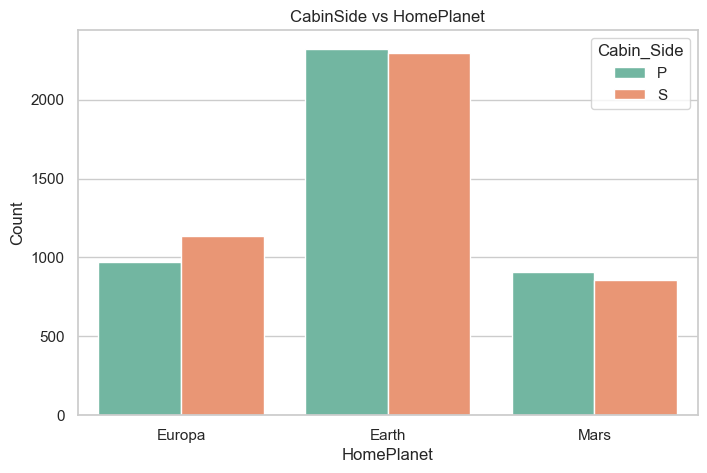

In [110]:
sns.set(style="whitegrid")

# 1. Side vs HomePlanet
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='HomePlanet', hue='cabin_side', palette='Set2')
plt.title('CabinSide vs HomePlanet')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.legend(title='Cabin_Side', loc='upper right')
plt.show()

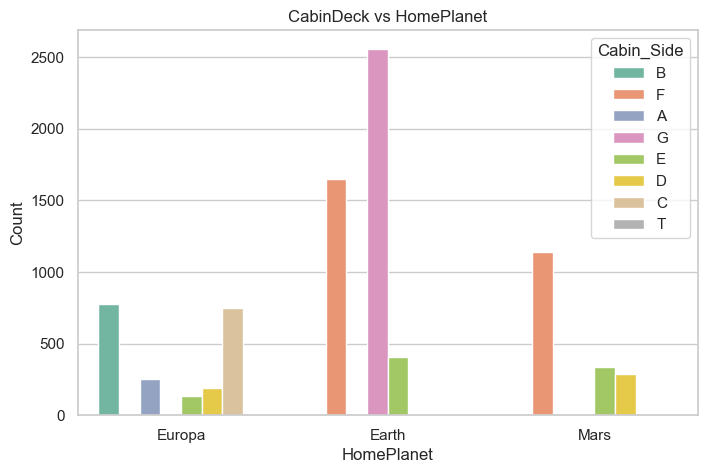

In [114]:
sns.set(style="whitegrid")

# 2. Side vs HomePlanet
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='HomePlanet', hue='cabin_deck', palette='Set2')
plt.title('CabinDeck vs HomePlanet')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.legend(title='Cabin_Side', loc='upper right')
plt.show()

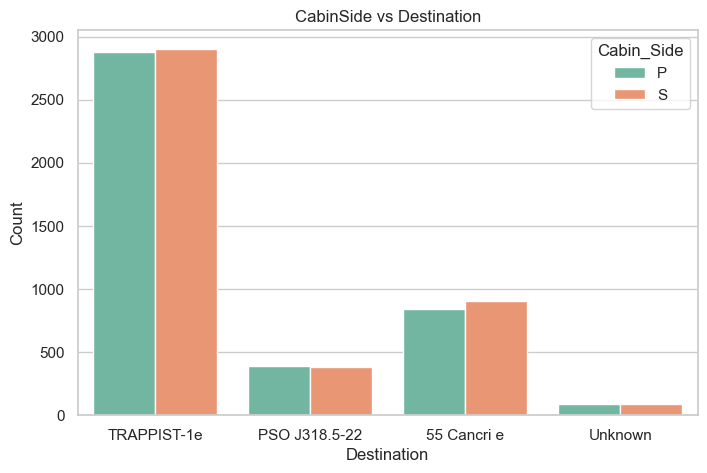

In [122]:
sns.set(style="whitegrid")

# 3. Side vs Destination
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Destination', hue='cabin_side', palette='Set2')
plt.title('CabinSide vs Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.legend(title='Cabin_Side', loc='upper right')
plt.show()

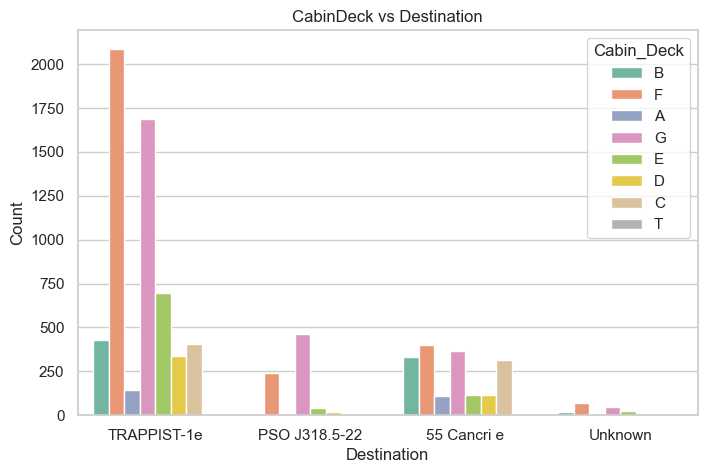

In [126]:
sns.set(style="whitegrid")

# 4. Side vs Destination
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Destination', hue='cabin_deck', palette='Set2')
plt.title('CabinDeck vs Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.legend(title='Cabin_Deck', loc='upper right')
plt.show()

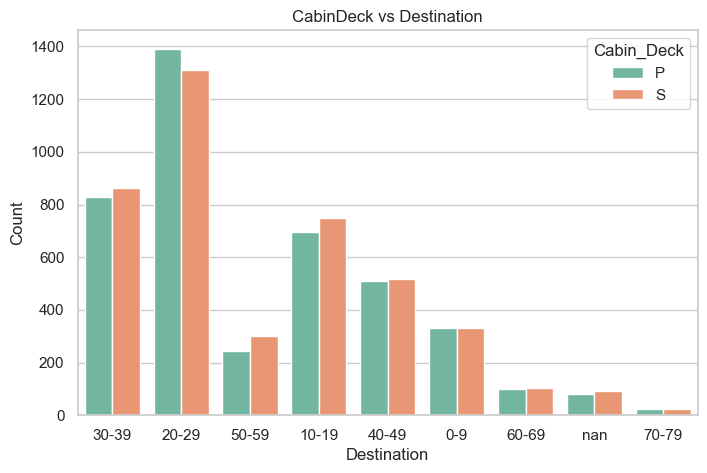

In [137]:
sns.set(style="whitegrid")

# 4. Side vs Destination
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='AgeGroup', hue='cabin_side', palette='Set2')
plt.title('CabinDeck vs Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.legend(title='Cabin_Deck', loc='upper right')
plt.show()

Summary Statistics for cabin_num:
count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: cabin_num, dtype: float64

Unique Values in cabin_num:
[0.000e+00 1.000e+00 2.000e+00 ... 1.892e+03 1.893e+03 1.894e+03]


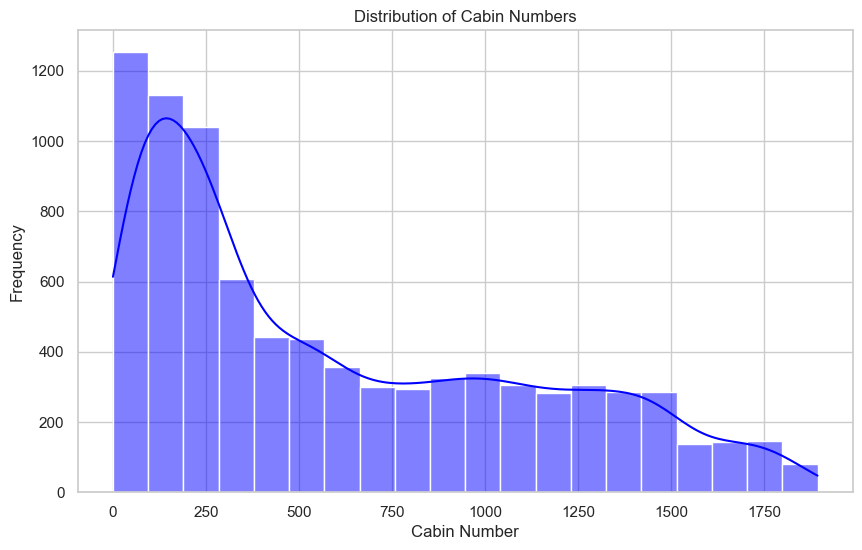

In [116]:
# Convert cabin_num to numeric (handling errors by coercing invalid values to NaN)
df['cabin_num'] = pd.to_numeric(df['cabin_num'], errors='coerce')

# Detailed analysis of cabin_num
print("Summary Statistics for cabin_num:")
print(df['cabin_num'].describe())

print("\nUnique Values in cabin_num:")
print(df['cabin_num'].unique())

# Visualize the distribution of cabin_num
plt.figure(figsize=(10, 6))
sns.histplot(df['cabin_num'].dropna(), bins=20, kde=True, color='blue')
plt.title('Distribution of Cabin Numbers')
plt.xlabel('Cabin Number')
plt.ylabel('Frequency')
plt.show()

         Cabin  cabin_num cabin_num_bucket
0        B/0/P        0.0              low
1        F/0/S        0.0              low
2        A/0/S        0.0              low
3        A/0/S        0.0              low
4        F/1/S        1.0              low
...        ...        ...              ...
8688    A/98/P       98.0              low
8689  G/1499/S     1499.0      medium-high
8690  G/1500/S     1500.0      medium-high
8691   E/608/S      608.0       medium-low
8692   E/608/S      608.0       medium-low

[8693 rows x 3 columns]


/var/folders/gm/ptz_rd3s5fv5m6lks9m633wr0000gn/T/ipykernel_43015/2578938398.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='cabin_num_bucket', order=labels, palette='viridis')


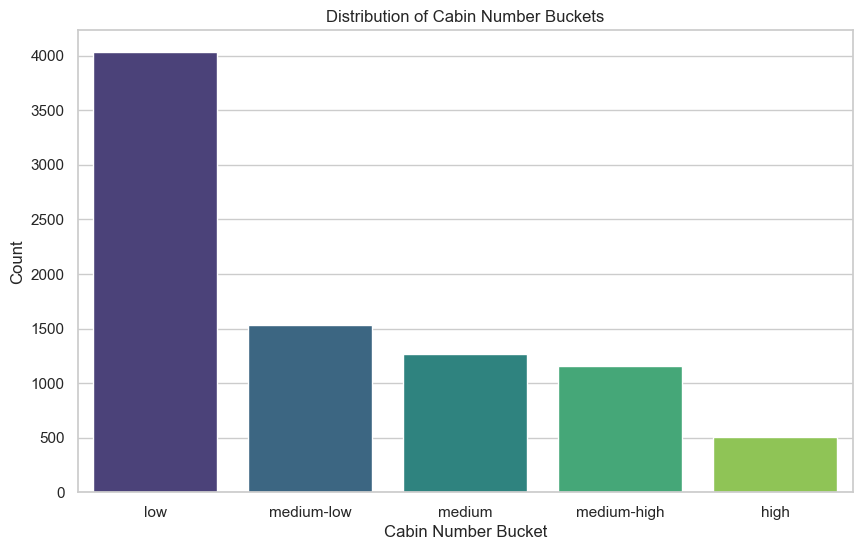

In [118]:
# Define the number of buckets and labels
num_buckets = 5
labels = ['low', 'medium-low', 'medium', 'medium-high', 'high']

# Create bins based on the range of cabin_num
min_num = df['cabin_num'].min()
max_num = df['cabin_num'].max()
bins = np.linspace(min_num, max_num, num_buckets + 1)

# Bucketize cabin_num
df['cabin_num_bucket'] = pd.cut(df['cabin_num'], bins=bins, labels=labels, include_lowest=True)

# Display the updated DataFrame
print(df[['Cabin', 'cabin_num', 'cabin_num_bucket']])

# Visualize the distribution of cabin_num_bucket
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cabin_num_bucket', order=labels, palette='viridis')
plt.title('Distribution of Cabin Number Buckets')
plt.xlabel('Cabin Number Bucket')
plt.ylabel('Count')
plt.show()

In [120]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,Last_Name,Deck,Num,Side,AgeGroup,cabin_deck,cabin_num,cabin_side,cabin_num_bucket
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,Ofracculy,B,0,P,30-39,B,0.0,P,low
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,Vines,F,0,S,20-29,F,0.0,S,low
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,Susent,A,0,S,50-59,A,0.0,S,low
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,False,Susent,A,0,S,30-39,A,0.0,S,low
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,True,Santantines,F,1,S,10-19,F,1.0,S,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,False,Noxnuther,A,98,P,40-49,A,98.0,P,low
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,False,Mondalley,G,1499,S,10-19,G,1499.0,S,medium-high
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,True,Connon,G,1500,S,20-29,G,1500.0,S,medium-high
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,False,Hontichre,E,608,S,30-39,E,608.0,S,medium-low


In [86]:
#Let's plot CryoSleep against HomePlanet; Destination and Cabin

In [88]:
df= df_filled

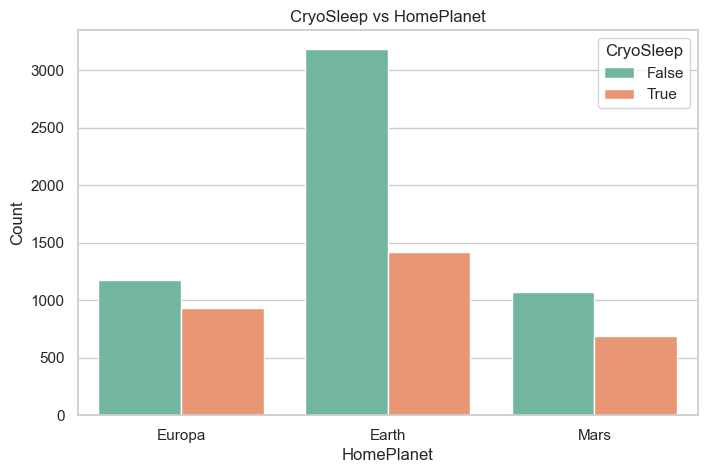

In [90]:
sns.set(style="whitegrid")

# 1. CryoSleep vs HomePlanet
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='HomePlanet', hue='CryoSleep', palette='Set2')
plt.title('CryoSleep vs HomePlanet')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.legend(title='CryoSleep', loc='upper right')
plt.show()

/var/folders/gm/ptz_rd3s5fv5m6lks9m633wr0000gn/T/ipykernel_43015/4182525173.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Destination'].fillna('Unknown', inplace=True)


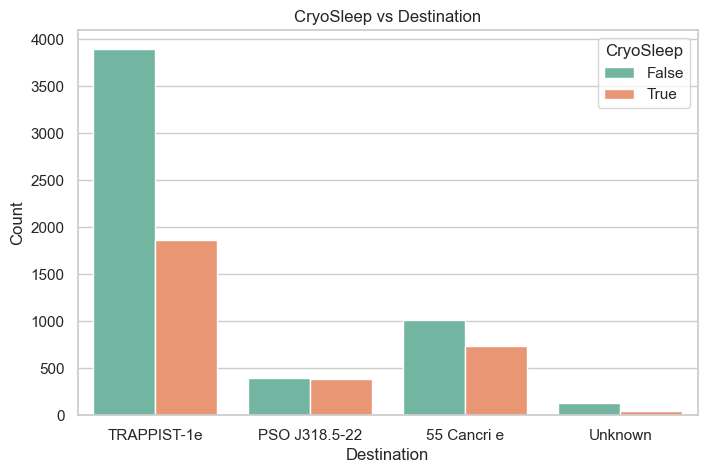

In [92]:
# 2. CryoSleep vs Destination
# Handle NaN values in Destination by replacing them with "Unknown"
df['Destination'].fillna('Unknown', inplace=True)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Destination', hue='CryoSleep', palette='Set2')
plt.title('CryoSleep vs Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.legend(title='CryoSleep', loc='upper right')
plt.show()

/var/folders/gm/ptz_rd3s5fv5m6lks9m633wr0000gn/T/ipykernel_43015/4125765024.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Deck'].fillna('Unknown', inplace=True)
/var/folders/gm/ptz_rd3s5fv5m6lks9m633wr0000gn/T/ipykernel_43015/4125765024.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

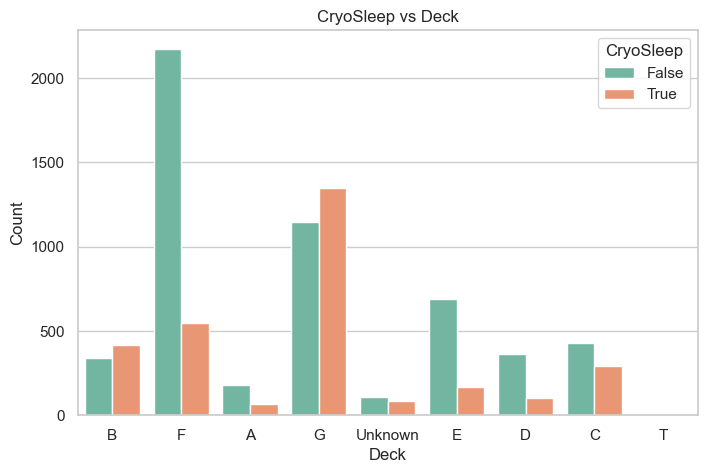

In [94]:
# 3. CryoSleep vs Cabin (split into Deck, Num, Side)
# Split the Cabin column into Deck, Num, and Side
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

# Handle NaN values in Deck, Num, and Side by replacing them with "Unknown"
df['Deck'].fillna('Unknown', inplace=True)
df['Num'].fillna('Unknown', inplace=True)
df['Side'].fillna('Unknown', inplace=True)

# Plot CryoSleep vs Deck
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Deck', hue='CryoSleep', palette='Set2')
plt.title('CryoSleep vs Deck')
plt.xlabel('Deck')
plt.ylabel('Count')
plt.legend(title='CryoSleep', loc='upper right')
plt.show()

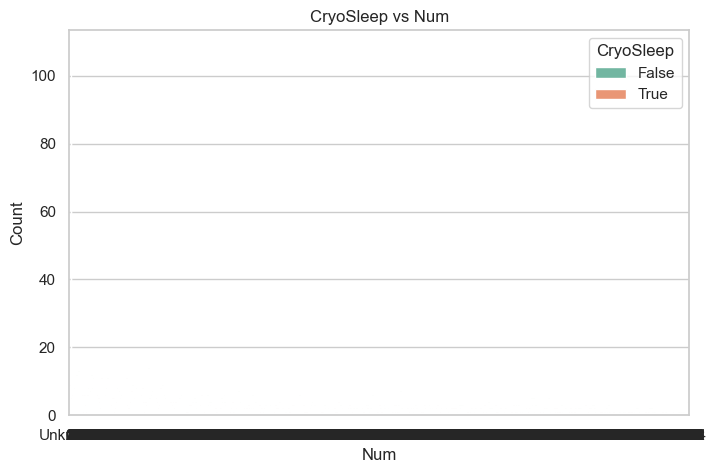

In [96]:
# Plot CryoSleep vs Num
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Num', hue='CryoSleep', palette='Set2')
plt.title('CryoSleep vs Num')
plt.xlabel('Num')
plt.ylabel('Count')
plt.legend(title='CryoSleep', loc='upper right')
plt.show()

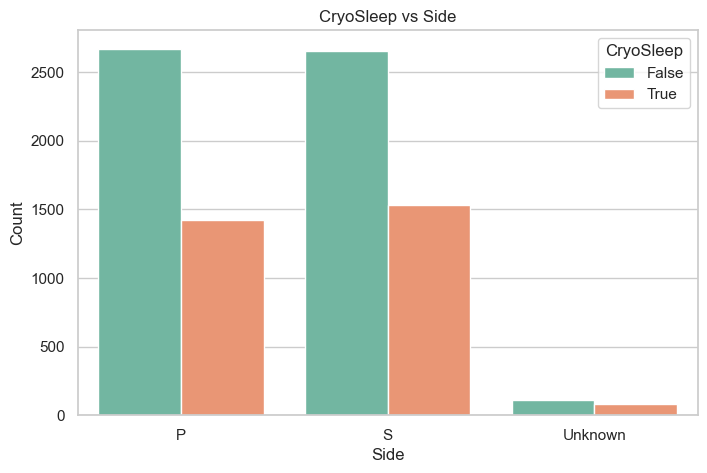

In [98]:
# Plot CryoSleep vs Side
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Side', hue='CryoSleep', palette='Set2')
plt.title('CryoSleep vs Side')
plt.xlabel('Side')
plt.ylabel('Count')
plt.legend(title='CryoSleep', loc='upper right')
plt.show()

/var/folders/gm/ptz_rd3s5fv5m6lks9m633wr0000gn/T/ipykernel_43015/4189275815.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AgeGroup'].fillna('Unknown', inplace=True)


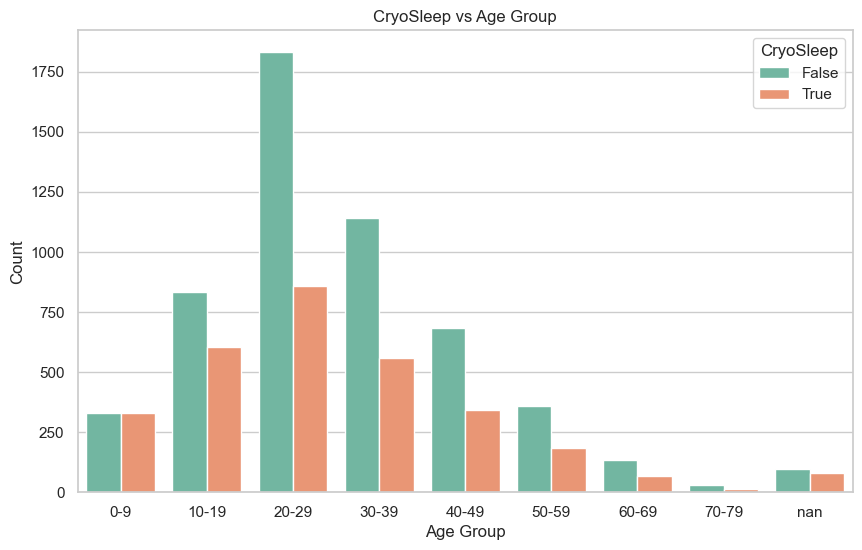

In [104]:
# 4. CryoSleep vs Age (bucketized into age groups of 10 years)
# Create age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=range(0, 101, 10), right=False, labels=[f'{i}-{i+9}' for i in range(0, 100, 10)])

# Convert AgeGroup to string type to allow adding "Unknown"
df['AgeGroup'] = df['AgeGroup'].astype(str)

# Handle NaN values in AgeGroup by replacing them with "Unknown"
df['AgeGroup'].fillna('Unknown', inplace=True)

# Plot CryoSleep vs AgeGroup
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='AgeGroup', hue='CryoSleep', palette='Set2', order=sorted(df['AgeGroup'].unique()))
plt.title('CryoSleep vs Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='CryoSleep', loc='upper right')
plt.show()